This project aims to provide a basic understanding about the crime scene of the City of Chicago

## Importing  libraries

In [1]:
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import Point
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

## Data preprocessing

In [2]:
cols = ['Date', 'Primary Type', 'Arrest', 'Domestic', 'Community Area', 'Year', 'Latitude', 'Longitude', 'Location Description']

df = pd.read_csv('Crimes_-_2001_to_Present.csv', usecols=cols, dtype={'Primary Type': 'category', 'Year': 'int16'}, parse_dates=['Date'])
df.info(verbose=False, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7451780 entries, 0 to 7451779
Columns: 9 entries, Date to Longitude
dtypes: bool(2), category(1), datetime64[ns](1), float64(3), int16(1), object(1)
memory usage: 747.1 MB


In [3]:
df.head()

,Date,Primary Type,Location Description,Arrest,Domestic,Community Area,Year,Latitude,Longitude
0,2015-09-05 13:30:00,BATTERY,RESIDENCE,False,True,61.0,2015,41.815117,-87.670000
1,2015-09-04 11:30:00,THEFT,CTA BUS,False,False,25.0,2015,41.895080,-87.765400
2,2018-09-01 00:01:00,THEFT,RESIDENCE,False,True,44.0,2018,NaN,NaN
3,2015-09-05 12:45:00,NARCOTICS,SIDEWALK,True,False,21.0,2015,41.937406,-87.716650
4,2015-09-05 13:00:00,ASSAULT,APARTMENT,False,True,25.0,2015,41.881903,-87.755121


In [4]:
communities = gpd.read_file('chicago_community_areas.geojson.txt')

First check for missing values

In [5]:
df.isnull().sum()

Date                         0
Primary Type                 0
Location Description      8731
Arrest                       0
Domestic                     0
Community Area          613479
Year                         0
Latitude                 74929
Longitude                74929
dtype: int64

In [6]:
df.dropna(subset=['Community Area', 'Latitude', 'Longitude'], how='all', inplace=True)
df[['Community Area', 'Latitude', 'Longitude']].isnull().sum()
# Removed 9203 rows

Community Area    604276
Latitude           65726
Longitude          65726
dtype: int64

Let's check if there are any records where only latitude or only longitude is set

In [7]:
df[(pd.notna(df.Latitude) & pd.isna(df.Longitude)) |  (pd.isna(df.Latitude) & pd.notna(df.Longitude))].shape

(0, 9)

In [8]:
missing_community_areas = df[pd.isna(df['Community Area'])].copy()
missing_community_areas.groupby('Year').size()

Year
2001    477127
2002    126020
2003        43
2004        63
2005        48
2006        44
2007       153
2008       200
2009       196
2010       184
2011       174
2012        22
2013         1
2020         1
dtype: int64

In [9]:
df.drop(df[df.Year <= 2002].index, inplace=True)
# Dropped 963487 rows
df.drop(df[df.Year >= 2021].index, inplace=True)

We define two helper functions to derive the community area from a given pair of latitude and longitude

In [10]:
def get_community_by_coordinates(latitude, longitude):
    
    community_areas = communities
    point = Point(longitude, latitude)
    polygons = community_areas.geometry
    for polygon in polygons:
        if point.within(polygon):
            return community_areas.area_num_1[community_areas.geometry == polygon].iloc[0]
        
def get_community(area, latitude, longitude):
   
    area_number = area
    if pd.isna(area):
        area_number = get_community_by_coordinates(latitude, longitude)
        return area_number
    return area_number

In [11]:
df['Community Area'] = df.apply(lambda row: get_community(row['Community Area'], row['Latitude'], row['Longitude']), axis=1)
df[['Community Area']].isnull().sum()

Community Area    11
dtype: int64

In [12]:
df.drop(df[df['Community Area'].isnull()].index, inplace=True)
df[['Community Area']].isnull().sum()

Community Area    0
dtype: int64

In [13]:
df['Community Area'] = df['Community Area'].astype(int)
communities['area_num_1'] = communities['area_num_1'].astype(int)

In [14]:
df[df['Community Area'] == 0].shape

(70, 9)

In [15]:
df.drop(df[df['Community Area'] == 0].index, inplace=True)

In [16]:
df.drop(['Latitude', 'Longitude'], axis=1, inplace=True)

In [17]:
df['Month'] = pd.DatetimeIndex(df.Date).month
df['Weekday'] = pd.DatetimeIndex(df.Date).day_of_week
df['Hour'] = pd.DatetimeIndex(df.Date).hour

In [18]:
# Save final, cleaned dataset
#df.to_csv('cleaned_dataset.csv')

In [19]:
df.shape

(6289700, 10)

Our final dataset to work with has **6,289,700 rows** and **9 columns**

# Data Modeling

For this project we have three business questions we can answer with pure data analysis. For the sixth question we are using a simple machine learning approach to get our results.

# What are the types of crimes that happen in Chicago?

In [20]:
crimetypegb=df.groupby(["Primary Type"])["Primary Type"].count()/len(df)*100
crimetypegb.sort_values(ascending=False, inplace=True)
print(crimetypegb)

Primary Type
THEFT                                21.202410
BATTERY                              18.153998
CRIMINAL DAMAGE                      11.363674
NARCOTICS                            10.074535
ASSAULT                               6.312511
OTHER OFFENSE                         6.171757
BURGLARY                              5.665548
MOTOR VEHICLE THEFT                   4.481104
DECEPTIVE PRACTICE                    4.407682
ROBBERY                               3.749304
CRIMINAL TRESPASS                     2.831709
WEAPONS VIOLATION                     1.233715
PROSTITUTION                          0.905258
OFFENSE INVOLVING CHILDREN            0.731386
PUBLIC PEACE VIOLATION                0.724422
CRIM SEXUAL ASSAULT                   0.385138
SEX OFFENSE                           0.373118
INTERFERENCE WITH PUBLIC OFFICER      0.266022
GAMBLING                              0.201743
LIQUOR LAW VIOLATION                  0.181376
ARSON                                 0.161009


Text(0, 0.5, 'Occurrence rate (%)')

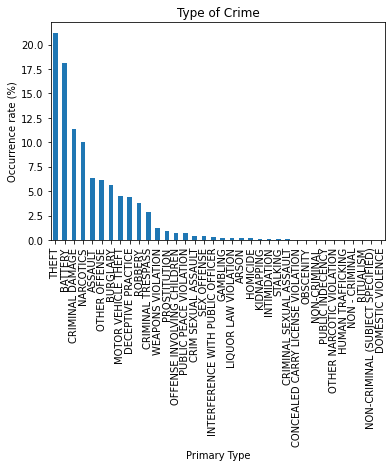

In [21]:
crimetypegb.plot(kind='bar',title="Type of Crime")
plt.ylabel('Occurrence rate (%)')

## When do crimes in Chicago happen?

In [22]:
crimes_yearly = df.groupby('Year').size()
crimes_monthly = df.groupby('Month').size()
crimes_weekday = df.groupby('Weekday').size()
crimes_hour = df.groupby('Hour').size()

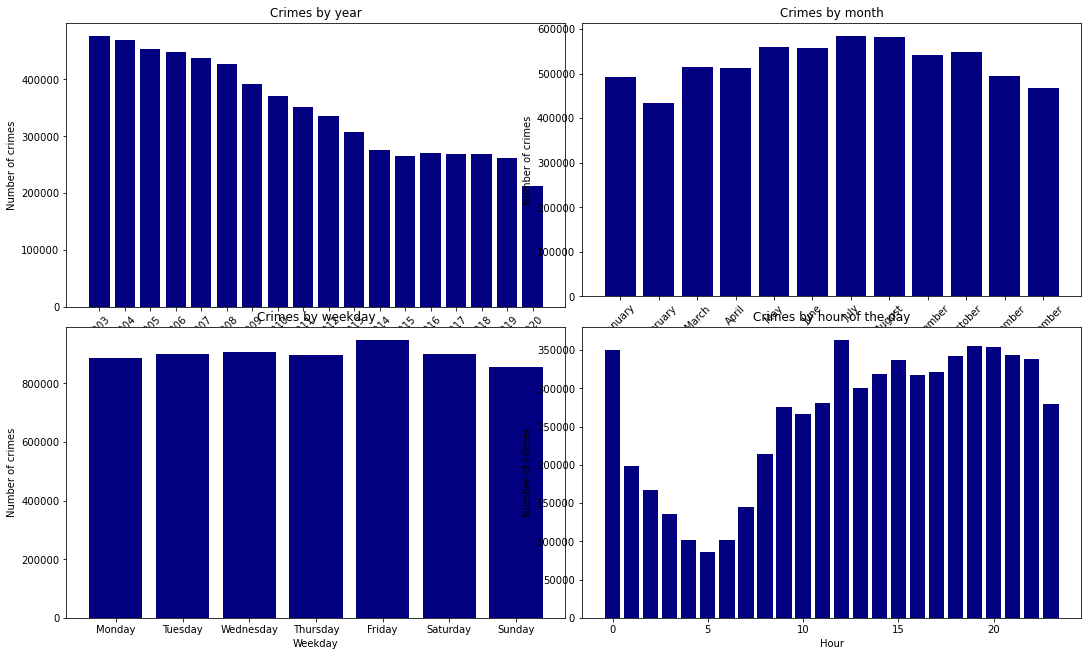

In [23]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots(constrained_layout=True)
fig.set_figheight(9)
fig.set_figwidth(15)
plt.subplot(2, 2, 1)
plt.bar(crimes_yearly.index.astype(str), crimes_yearly.values, color='navy')
plt.title('Crimes by year')
plt.xlabel('Year')
plt.ylabel('Number of crimes')
plt.xticks(rotation=45)
plt.subplot(2, 2, 2)
plt.bar(months, crimes_monthly.values, color='navy')
plt.title('Crimes by month')
plt.xlabel('Month')
plt.ylabel('Number of crimes')
plt.xticks(rotation=45)
plt.subplot(2, 2, 3)
plt.bar(weekdays, crimes_weekday.values, color='navy')
plt.title('Crimes by weekday')
plt.xlabel('Weekday')
plt.ylabel('Number of crimes')
plt.ticklabel_format(style='plain', axis='y')
plt.subplot(2, 2, 4)
plt.bar(crimes_hour.index, crimes_hour.values, color='navy')
plt.title('Crimes by hour of the day')
plt.xlabel('Hour')
plt.ylabel('Number of crimes')

plt.show()
#plt.savefig('crimes_seasonality.png', dpi=100)

## What are the top 3 crimes for each community area?

In [24]:
comm_crimes_grouped = df.groupby('Community Area')['Primary Type'].value_counts()
comm_crimes_grouped

Community Area  Primary Type                     
1               THEFT                                20945
                BATTERY                              17662
                CRIMINAL DAMAGE                      11431
                NARCOTICS                             8951
                OTHER OFFENSE                         6480
                                                     ...  
77              OBSCENITY                                6
                NON-CRIMINAL                             2
                PUBLIC INDECENCY                         2
                CONCEALED CARRY LICENSE VIOLATION        1
                OTHER NARCOTIC VIOLATION                 1
Name: Primary Type, Length: 2378, dtype: int64

In [25]:
def get_geo_data_for_top_n_crime(data_grouped_by_crimes, nth_crime):
    
    comm_crimes_nth = data_grouped_by_crimes.to_frame('Count').groupby(level=0, as_index=False).nth(nth_crime - 1)
    comm_crimes_nth.index.rename(names=['Community Area', 'Primary Type'], level=[0, 1], inplace=True)
    comm_crimes_nth = comm_crimes_nth.reset_index()
    comm_crimes_nth['Primary Type'] = comm_crimes_nth['Primary Type'].cat.remove_unused_categories()
    
    return communities[['area_num_1', 'geometry']].merge(comm_crimes_nth, how='inner', left_on='area_num_1', right_on='Community Area').drop(columns=['area_num_1'])

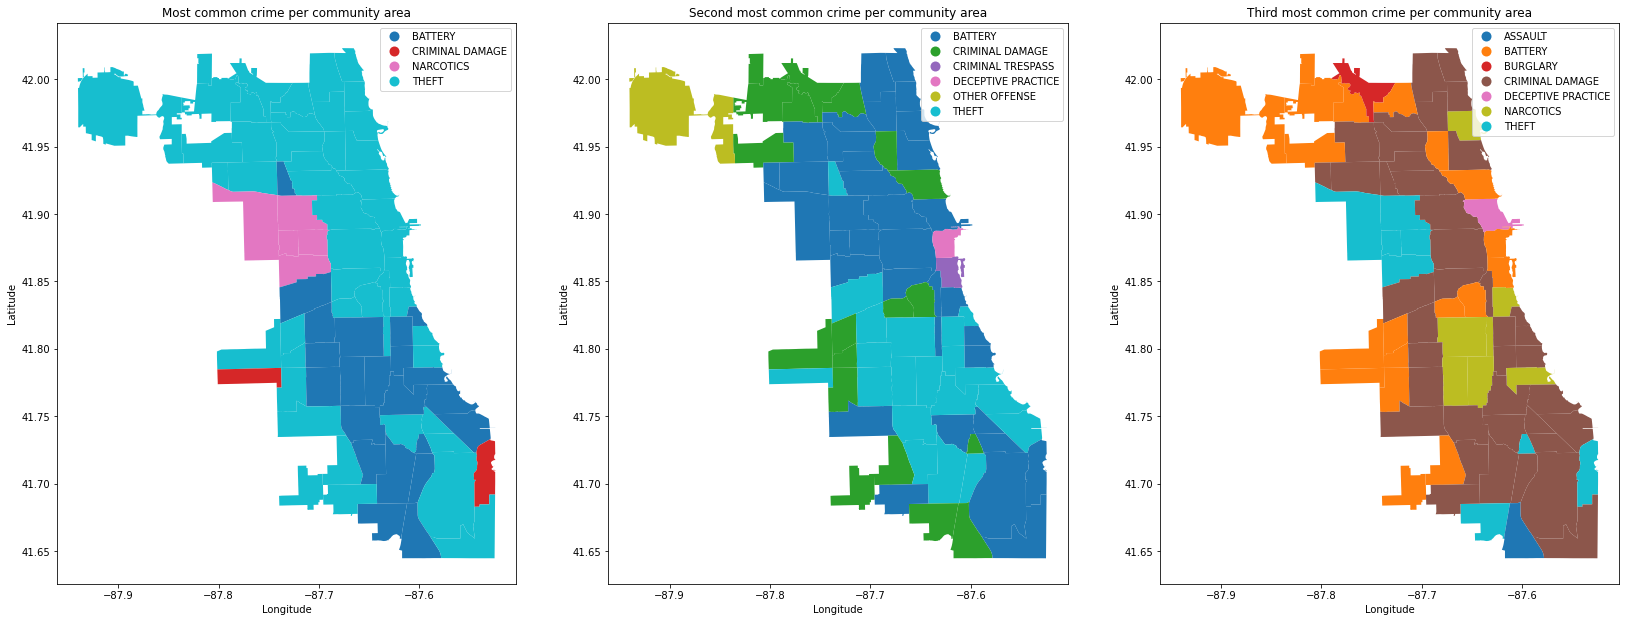

In [26]:
f, axes = plt.subplots(figsize=(28, 20), ncols=3, nrows=1)
titles = {
    1: 'Most common crime per community area',
    2: 'Second most common crime per community area',
    3: 'Third most common crime per community area'
}
for i in range(3):
    crime_geodata = get_geo_data_for_top_n_crime(comm_crimes_grouped, i + 1)
    axes[i].set_title(titles[i + 1])
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel('Latitude')
    crime_geodata.plot(ax=axes[i], column='Primary Type', categorical=True, legend=True)
#plt.savefig('crimes_per_community_area.png', dpi=100)

# The 4 major types of crimes by location

In [27]:
import matplotlib.pyplot as pltd
def topfour(row):
    keep = ["THEFT", "BATTERY", "NARCOTICS", "CRIMINAL DAMAGE"]
    if row not in keep:
        return "OTHERS"
    else:
        return row

In [28]:
df["New Type"] = df["Primary Type"].apply(topfour)

In [29]:
df

,Date,Primary Type,Location Description,Arrest,Domestic,Community Area,Year,Month,Weekday,Hour,New Type
0,2015-09-05 13:30:00,BATTERY,RESIDENCE,False,True,61,2015,9,5,13,BATTERY
1,2015-09-04 11:30:00,THEFT,CTA BUS,False,False,25,2015,9,4,11,THEFT
2,2018-09-01 00:01:00,THEFT,RESIDENCE,False,True,44,2018,9,5,0,THEFT
3,2015-09-05 12:45:00,NARCOTICS,SIDEWALK,True,False,21,2015,9,5,12,NARCOTICS
4,2015-09-05 13:00:00,ASSAULT,APARTMENT,False,True,25,2015,9,5,13,OTHERS
...,...,...,...,...,...,...,...,...,...,...,...
7451641,2004-08-16 22:35:00,HOMICIDE,HALLWAY,False,False,43,2004,8,0,22,OTHERS
7451695,2019-10-15 12:15:00,HOMICIDE,STREET,True,False,61,2019,10,1,12,OTHERS
7451716,2004-08-10 03:25:00,HOMICIDE,STREET,True,False,24,2004,8,1,3,OTHERS
7451726,2017-02-14 00:00:00,THEFT,APARTMENT,False,False,38,2017,2,1,0,THEFT


<AxesSubplot:>

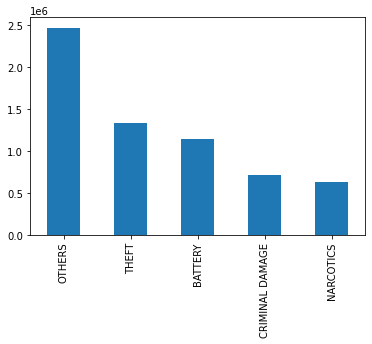

In [30]:
df['New Type'].value_counts().plot(kind='bar')

In [31]:
def plotsplit(cnam, title):
    datasplit = df.groupby([cnam, "New Type"])[cnam].count().unstack()
    # Convert everything to percentage for normalization, so we can compare!
    datasplit= datasplit.apply(lambda c: c / c.sum() * 100, axis=1)
    # Reorder columns
    datasplit = datasplit[['OTHERS', 'CRIMINAL DAMAGE', 'NARCOTICS', 'BATTERY', 'THEFT']]
    datasplit.plot(kind = "bar", stacked = True, title = title)
    plt.ylabel('Fraction of Crime Type (%)')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=3, fancybox=True, shadow=True)
    plt.ylim([0,120])

In [32]:
pltd.rcParams["figure.figsize"] = (30,20)

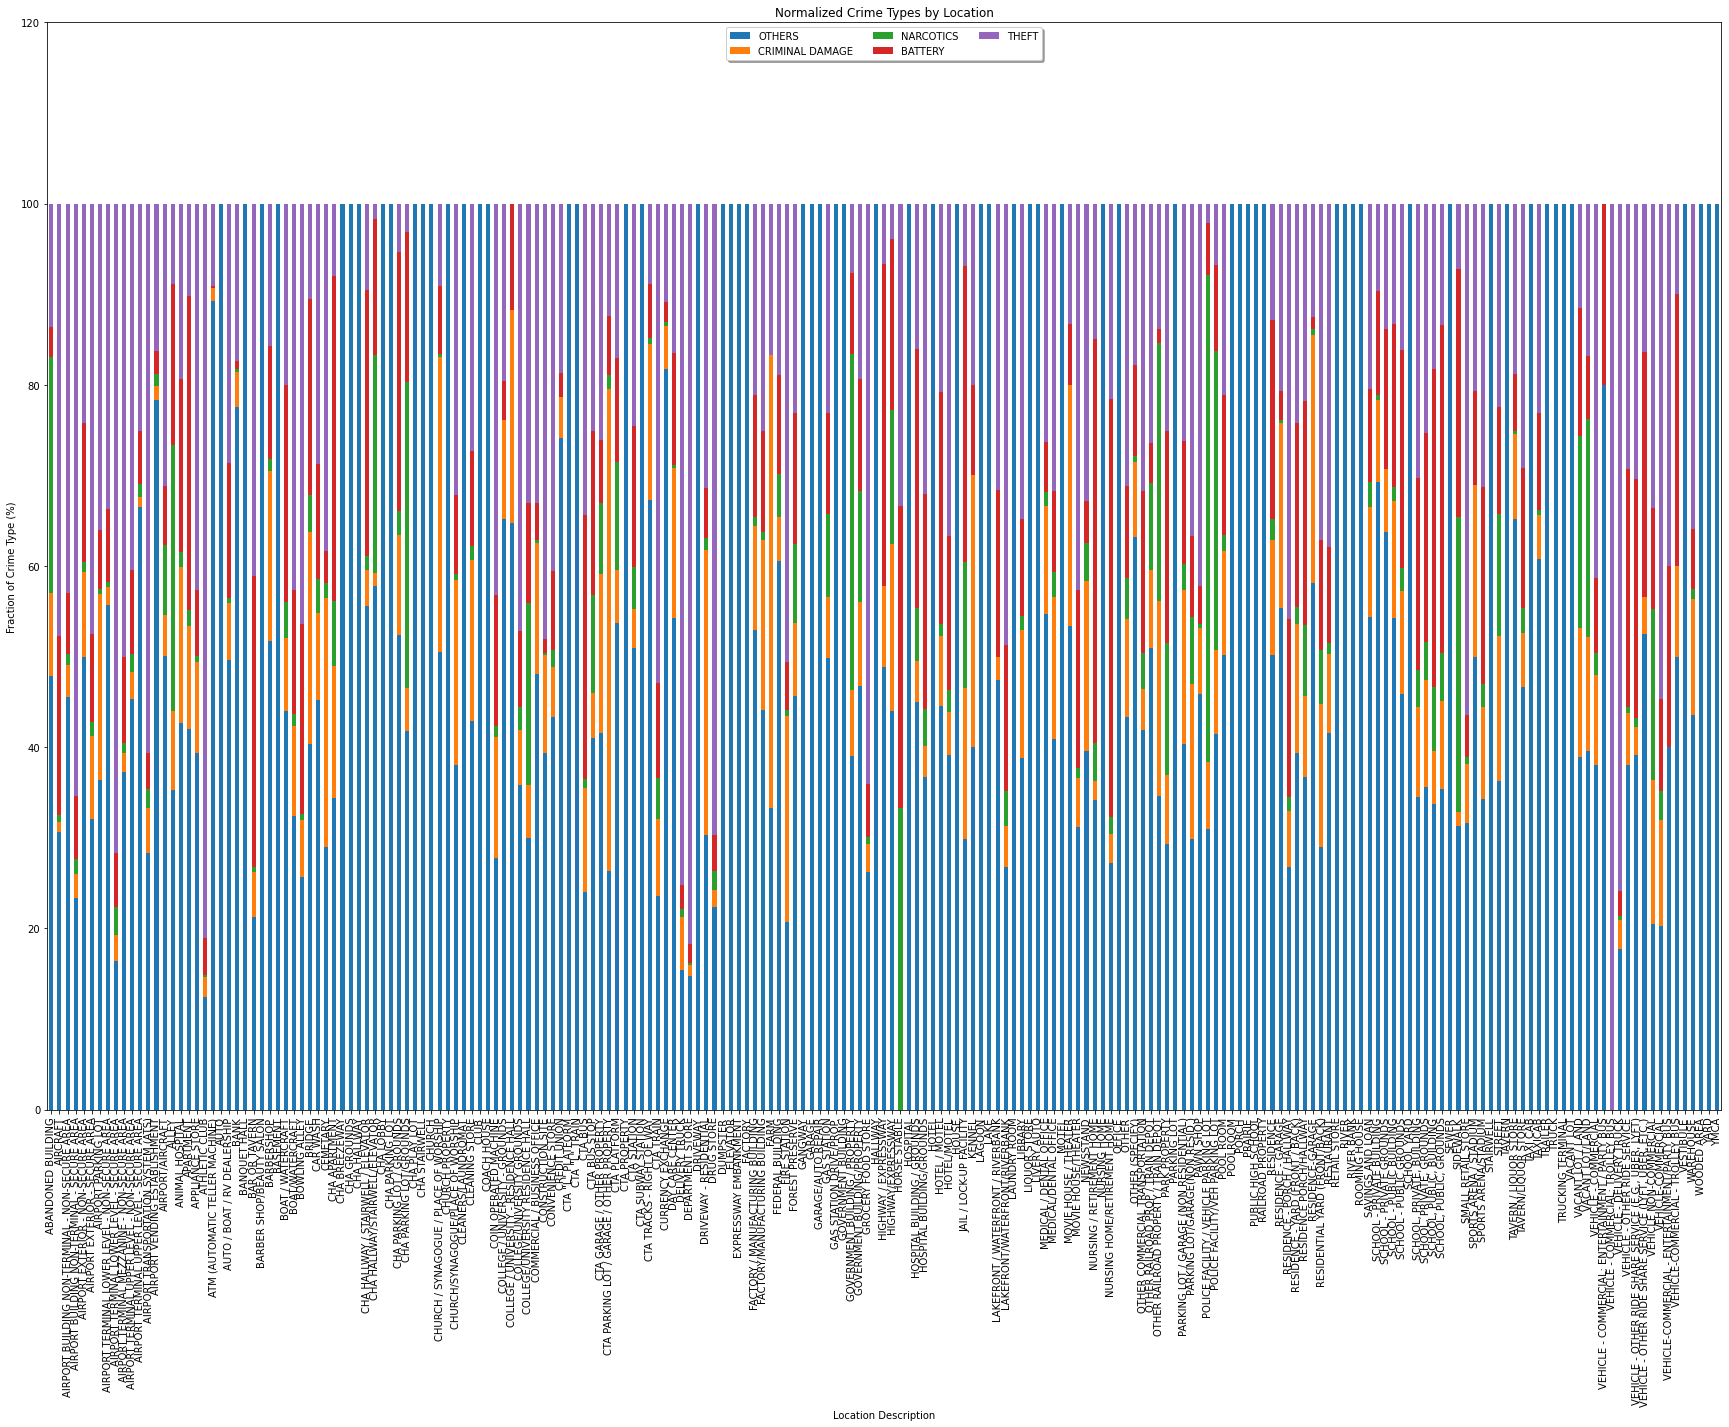

In [33]:
plotsplit("Location Description", "Normalized Crime Types by Location")

## Where do the most crimes happen?

In [34]:
comm_crimes = df.groupby('Community Area').size().to_frame('Count')
comm_crimes

,Count
Community Area,
1,95803
2,79581
3,90642
4,44300
5,37095
...,...
73,74925
74,14057
75,50294


In [35]:
def get_geo_data_for_crime(crime):
  
    theft_data = df[df['Primary Type'] == crime]
    theft_data_grouped = theft_data.groupby('Community Area').size().to_frame('Count')
    
    return communities[['area_num_1', 'geometry']].merge(theft_data_grouped, how='inner', left_on='area_num_1', right_on='Community Area').drop(columns=['area_num_1'])

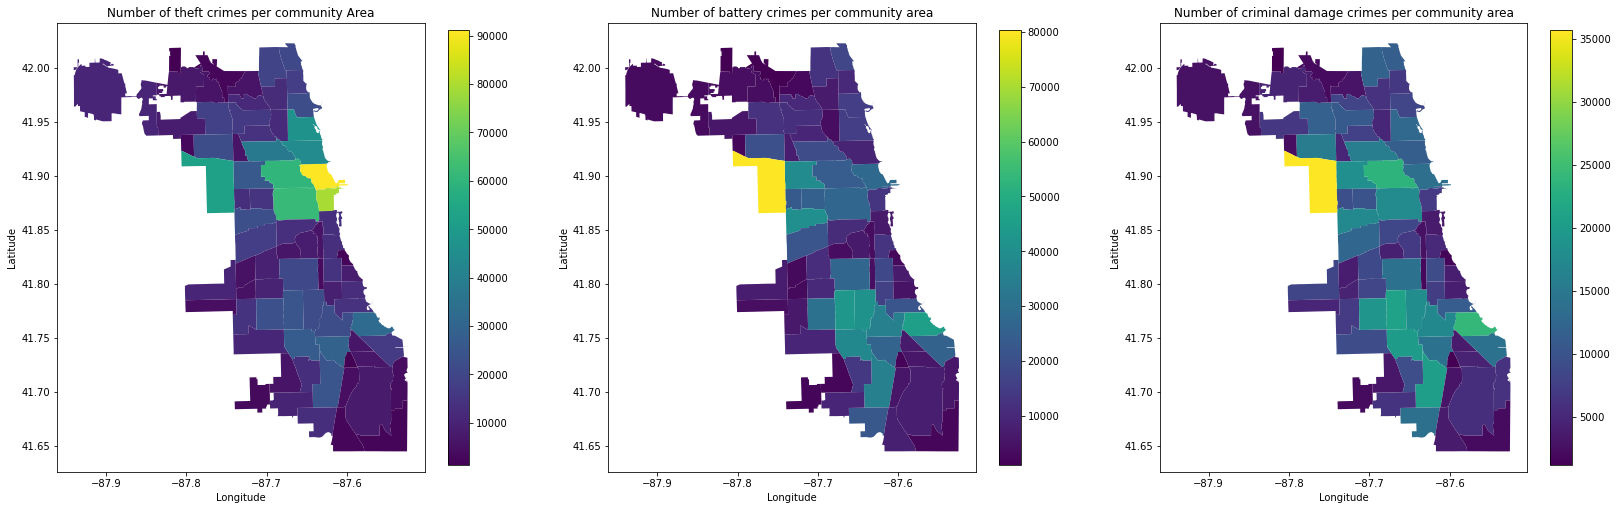

In [36]:
f, axes = plt.subplots(figsize=(28, 20), ncols=3, nrows=1)
titles = {
    1: 'Number of theft crimes per community Area',
    2: 'Number of battery crimes per community area',
    3: 'Number of criminal damage crimes per community area'
}
crimes = ['THEFT', 'BATTERY', 'CRIMINAL DAMAGE']
for i in range(3):
    crime_geodata = get_geo_data_for_crime(crimes[i])
    axes[i].set_title(titles[i + 1])
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel('Latitude')
    crime_geodata.plot(column='Count', ax=axes[i], legend=True, legend_kwds={'shrink': 0.4})
#plt.savefig('crimes_heatmap.png', dpi=100)

## Can we predict if an arrest was made for a crime? 

First we get an overview about the different crime types in the dataset

In [37]:
df.groupby('Primary Type').size().sort_values(ascending=False)

Primary Type
THEFT                                1333568
BATTERY                              1141832
CRIMINAL DAMAGE                       714741
NARCOTICS                             633658
ASSAULT                               397038
OTHER OFFENSE                         388185
BURGLARY                              356346
MOTOR VEHICLE THEFT                   281848
DECEPTIVE PRACTICE                    277230
ROBBERY                               235820
CRIMINAL TRESPASS                     178106
WEAPONS VIOLATION                      77597
PROSTITUTION                           56938
OFFENSE INVOLVING CHILDREN             46002
PUBLIC PEACE VIOLATION                 45564
CRIM SEXUAL ASSAULT                    24224
SEX OFFENSE                            23468
INTERFERENCE WITH PUBLIC OFFICER       16732
GAMBLING                               12689
LIQUOR LAW VIOLATION                   11408
ARSON                                  10127
HOMICIDE                                95

In [38]:
arrest_data = df[['Primary Type', 'Arrest', 'Domestic', 'Community Area', 'Year', 'Month', 'Weekday', 'Hour']].copy()
arrest_data.head()

,Primary Type,Arrest,Domestic,Community Area,Year,Month,Weekday,Hour
0,BATTERY,False,True,61,2015,9,5,13
1,THEFT,False,False,25,2015,9,4,11
2,THEFT,False,True,44,2018,9,5,0
3,NARCOTICS,True,False,21,2015,9,5,12
4,ASSAULT,False,True,25,2015,9,5,13


Let's check how many crimes resulted in an arrest

In [39]:
arrest_data['Arrest'].value_counts(normalize=True)

False    0.731583
True     0.268417
Name: Arrest, dtype: float64

including crimes which have at least 100,000 records, as it showed to converge with enough iterations.

In [40]:
crime_types = arrest_data['Primary Type'].value_counts().loc[lambda x: x >= 100000].index.tolist()
arrest_data.drop(arrest_data[~arrest_data['Primary Type'].isin(crime_types)].index, inplace=True)

In [41]:
arrest_data['Primary Type'] = arrest_data['Primary Type'].cat.remove_unused_categories()

In [42]:
arrest_data = pd.get_dummies(arrest_data, columns=['Primary Type'])
arrest_data.head()

,Arrest,Domestic,Community Area,Year,Month,Weekday,Hour,Primary Type_ASSAULT,Primary Type_BATTERY,Primary Type_BURGLARY,Primary Type_CRIMINAL DAMAGE,Primary Type_CRIMINAL TRESPASS,Primary Type_DECEPTIVE PRACTICE,Primary Type_MOTOR VEHICLE THEFT,Primary Type_NARCOTICS,Primary Type_OTHER OFFENSE,Primary Type_ROBBERY,Primary Type_THEFT
0,False,True,61,2015,9,5,13,0,1,0,0,0,0,0,0,0,0,0
1,False,False,25,2015,9,4,11,0,0,0,0,0,0,0,0,0,0,1
2,False,True,44,2018,9,5,0,0,0,0,0,0,0,0,0,0,0,1
3,True,False,21,2015,9,5,12,0,0,0,0,0,0,0,1,0,0,0
4,False,True,25,2015,9,5,13,1,0,0,0,0,0,0,0,0,0,0


In [43]:
model = LogisticRegression(random_state=1, max_iter=300)

We split the data in train and test data in a 70% training, 30% testing

In [48]:
y = arrest_data['Arrest']
X = arrest_data.drop(['Arrest'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [49]:
model.fit(X_train, y_train)

C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=300, random_state=1)

# Evaluate the Results

In [50]:
y_pred = model.predict(X_test)
print('Accuracy on test data: {:.2f}'.format(model.score(X_test, y_test)))

Accuracy on test data: 0.87


In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.86      0.99      0.92   1340242
        True       0.93      0.51      0.66    441270

    accuracy                           0.87   1781512
   macro avg       0.90      0.75      0.79   1781512
weighted avg       0.88      0.87      0.86   1781512

